In [1]:
# Needed to import the pyavatar folder
import os
import sys
code_path = os.path.abspath(os.path.join('..'))
if code_path not in sys.path:
    sys.path.append(code_path)

In [2]:
import os
import numpy as np
import scipy.io
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
from scipy.stats.stats import pearsonr
from scipy.signal import butter, lfilter

from pyavatar.utilities import get_distance_wall, exclude_input_nodes, discard_warm_up_time, low_pass_filter

import pdb

# Explore the change of ws correlation with different alphas

Here the target is fixed (0.25 and I explored how different nodes correlate with the distance from the wall for different alphas)

In [3]:
# General settings
sim_length = 3e04
sim_length_short = sim_length - 5000
no_input_node = 58 # number of nodes (excluding input nodes)

# read in results and plot
base_path5 = '../Output/simulation/with_behaviour/w_search/testn_18'
alpha_range5 = np.arange(0, .0002, .000005)
all_ws5 = np.zeros((int(sim_length_short), len(alpha_range5)))

all_min_dist5 = np.zeros((int(sim_length_short), len(alpha_range5)))
corr_ws_mean5 = np.zeros((len(alpha_range5)))
# correlation between each node individually with the distance from the wall
corr_ws_nodes5 = np.zeros((no_input_node, len(alpha_range5)))

for ii, alpha5 in enumerate(alpha_range5):
    mat_path5 = os.path.join(base_path5, 'alpha_%.06f.mat' 
                               %(alpha5))

    simulation5 = scipy.io.loadmat(mat_path5)
    # chop warm up time and input nodes from the simulation
    simulation5 = discard_warm_up_time(simulation5)
    simulation5 = exclude_input_nodes(simulation5)
  
    # get min distance from the wall
    all_min_dist5[:, ii] = get_distance_wall(simulation5)
    # take the average of ws over nodes for each time point
    all_ws5[:, ii] = np.mean(simulation5['ws'], axis=1)
    # find the correlation between ws and min distance from the wall for each ii
    corr_ws_mean5[ii] = pearsonr(all_ws5[:, ii], all_min_dist5[:, ii])[0]
    
    # find the correlation between ws and each node seperatly
    for n in range(no_input_node):
        corr_ws_nodes5[n, ii] = pearsonr(simulation5['ws'][:, n], all_min_dist5[:, ii])[0]

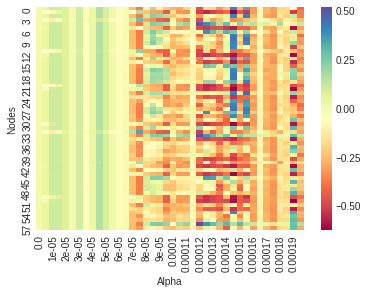

In [4]:
results5 = pd.DataFrame(corr_ws_nodes5, columns=alpha_range5)
heat_plt5 = sns.heatmap(results5, cmap='Spectral')
heat_plt5.set(xlabel='Alpha', ylabel='Nodes')
fig_heat_plt5 = heat_plt5.get_figure()

# Explore the alpha and target space

To get this results you can run: `python rww_mapping.py -gg --grids_alpha 0 .0003 --step_alpha .00001 --grids_target 0 .8 --step_target .05 --noise 0.00001 --analysis_type gridsearch --testn 18 --behaviour`

In [5]:
import pdb
# read in results and plot
base_path = '../Output/dynamic_analysis/with_behaviour/gridsearch/testn_18/gridsearch2'
# Due to rounding problems, I am typing out the range
alpha_range = np.arange(0, .0003, .00001)
target_range = np.arange(0, .75, .05)
corr_ws = np.zeros((len(alpha_range), len(target_range)))
corr_ws_nodes = np.zeros((len(alpha_range), len(target_range)))
mean_activity = np.zeros((len(alpha_range), len(target_range)))

for ii, alpha in enumerate(alpha_range):
    pickle_path = os.path.join(base_path, 'gridsearch_%.05f.pickle' %(alpha))
    with open(pickle_path, 'rb') as fh:
        all_results = pickle.load(fh)
    for jj, target in enumerate(target_range):
        target_i = '%.02f' %target
        
        # take mean activity over time
        mean_activity[ii, jj] = np.mean(all_results[target_i]['mean_activity_over_time'])
        corr_ws[ii, jj] = all_results[target_i]['correlation_ws_mean_nodes']
        corr_ws_nodes[ii, jj] = all_results[target_i]['correlation_ws_single_nodes_mean']

## WS

 The cross function of the plot represents the mean correlation over all nodes over time. The first time plot takes the mean acivity of all nodes and correlate with the distance from the wall. Whereas the second plot, correlates the activity of each node separatly and correlate with the distance from the wall and then takes the mean. 

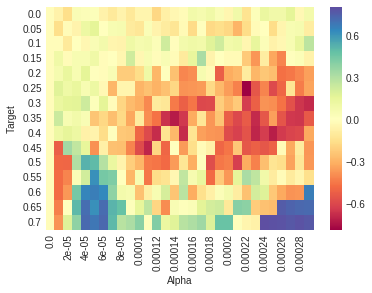

In [6]:
results6 = pd.DataFrame(corr_ws.T, index=target_range, columns=alpha_range)
heat_plt6 = sns.heatmap(results6, cmap='Spectral')
heat_plt6.set(xlabel='Alpha', ylabel='Target')
fig_heat_plt6 = heat_plt6.get_figure()

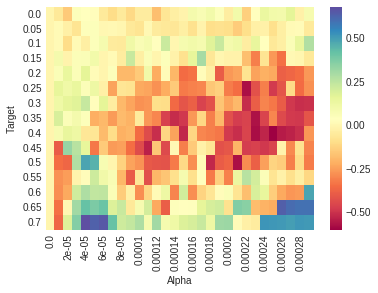

In [7]:
results7 = pd.DataFrame(corr_ws_nodes.T, index=target_range, columns=alpha_range)
heat_plt7 = sns.heatmap(results7, cmap='Spectral')
heat_plt7.set(xlabel='Alpha', ylabel='Target')
fig_heat_plt7 = heat_plt7.get_figure()

## Mean activity

The cross function shows how the mean activity changes as a function of the target and alpha

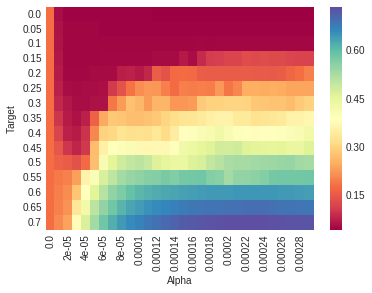

In [8]:
# plot the results
results5 = pd.DataFrame(mean_activity.T, index=target_range, columns=alpha_range)
heat_plt5 = sns.heatmap(results5, cmap='Spectral')
heat_plt5.set(xlabel='Alpha', ylabel='Target')
fig_heat_plt5 = heat_plt5.get_figure()

## Analysis of 4 different simulations

In [11]:
# Load data for 3 different simulations
path_good1 = '../Output/simulation/with_behaviour/gridsearch/testn_18/1_0.00020_0.25.mat'  # Target: 2.5 and Alpha: 2e-04
path_good2 = '../Output/simulation/with_behaviour/gridsearch/testn_18/1_0.00020_0.70.mat' # Target: 0.7 and Alpha: 2e-04
path_bad1 = '../Output/simulation/with_behaviour/gridsearch/testn_18/1_0.00002_0.70.mat'   # Target: 0.7 and Alpha: 2e-05
path_bad2 = '../Output/simulation/with_behaviour/gridsearch/testn_18/1_0.00002_0.25.mat'   # Target: 2.5 and Alpha: 2e-05

In [12]:
# Process the data to exclude nodes and warm up time
sim_1 = scipy.io.loadmat(path_good1)
simulation_1 = exclude_input_nodes(sim_1)
simulation_1 = discard_warm_up_time(sim_1)

sim_2 = scipy.io.loadmat(path_good2)
simulation_2 = exclude_input_nodes(sim_2)
simulation_2 = discard_warm_up_time(sim_2)

sim_3 = scipy.io.loadmat(path_bad1)
simulation_3 = exclude_input_nodes(sim_3)
simulation_3 = discard_warm_up_time(sim_3)

sim_4 = scipy.io.loadmat(path_bad2)
simulation_4 = exclude_input_nodes(sim_4)
simulation_4 = discard_warm_up_time(sim_4)


### ws

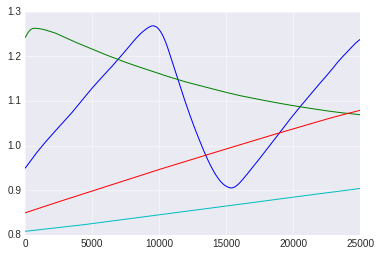

In [13]:
plt.plot(np.mean(simulation_1['ws'], axis=1))
plt.plot(np.mean(simulation_2['ws'], axis=1))
plt.plot(np.mean(simulation_3['ws'], axis=1))
plt.plot(np.mean(simulation_4['ws'], axis=1))

### Distance from the wall

In [14]:
# Get distance from the wall
cutoff = 0.6 # Hz
fs = 300 # Hz
order = 2

dd1 = get_distance_wall(simulation_1)
dd1 =low_pass_filter(cutoff, fs, order, dd1)

dd2 = get_distance_wall(simulation_2)
dd2 =low_pass_filter(cutoff, fs, order, dd2)

dd3 = get_distance_wall(simulation_3)
dd3 =low_pass_filter(cutoff, fs, order, dd3)

dd4 = get_distance_wall(simulation_4)
dd4 =low_pass_filter(cutoff, fs, order, dd4)

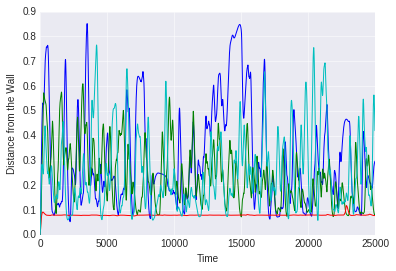

In [15]:
plt.plot(dd1)
plt.plot(dd2)
plt.plot(dd3)
plt.plot(dd4)

plt.xlabel('Time')
plt.ylabel('Distance from the Wall')

### Correlation ws and distance from the wall

In [16]:
print 'Target: 2.5 and Alpha: 2e-04' 
print pearsonr(np.mean(simulation_1['ws'], axis=1), dd1)
print 'Target: .7 and Alpha: 2e-04'
print pearsonr(np.mean(simulation_2['ws'], axis=1), dd2)
print 'Target: .7 and Alpha: 2e-05'
print pearsonr(np.mean(simulation_3['ws'], axis=1), dd3)
print 'Target: 2.5 and Alpha: 2e-05'
print pearsonr(np.mean(simulation_4['ws'], axis=1), dd4)


Target: 2.5 and Alpha: 2e-04
(-0.34426867274882794, 0.0)
Target: .7 and Alpha: 2e-04
(0.48831793429594655, 0.0)
Target: .7 and Alpha: 2e-05
(0.19574097276513747, 2.1929166559780217e-214)
Target: 2.5 and Alpha: 2e-05
(0.11877955776711079, 3.1388934730975468e-79)


### hs

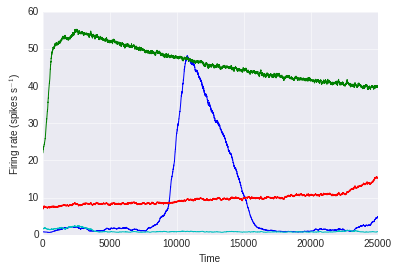

In [17]:
plt.plot(np.mean(simulation_1['hs'] * 1000, axis=1))
plt.plot(np.mean(simulation_2['hs'] * 1000, axis=1))
plt.plot(np.mean(simulation_3['hs'] * 1000, axis=1))
plt.plot(np.mean(simulation_4['hs'] * 1000, axis=1))

plt.xlabel('Time')
plt.ylabel('Firing rate (spikes s$^{-1}$)')

In [18]:
print pearsonr(np.mean(simulation_1['hs'], axis=1), dd1)
print pearsonr(np.mean(simulation_2['hs'], axis=1), dd2)
print pearsonr(np.mean(simulation_3['hs'], axis=1), dd3)
print pearsonr(np.mean(simulation_4['hs'], axis=1), dd4)

(0.12416369286869233, 1.8658440638759873e-86)
(0.32275888242058148, 0.0)
(0.18699633261586515, 1.6582598504937516e-195)
(-0.26840946671468124, 0.0)


## hs

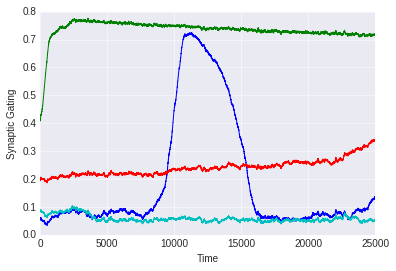

In [19]:
plt.plot(np.mean(simulation_1['xs'], axis=1))
plt.plot(np.mean(simulation_2['xs'], axis=1))
plt.plot(np.mean(simulation_3['xs'], axis=1))
plt.plot(np.mean(simulation_4['xs'], axis=1))

plt.xlabel('Time')
plt.ylabel('Synaptic Gating')